In [2]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf
print("tensorflow version: ", tf.__version__)


tensorflow version:  2.10.0


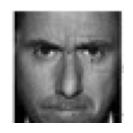

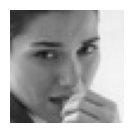

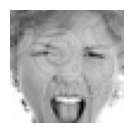

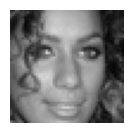

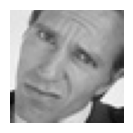

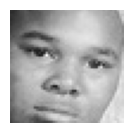

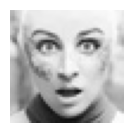

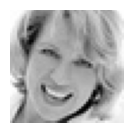

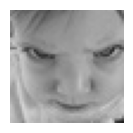

In [3]:
images = glob("train/**/**")
for i in range(9):
    image=random.choice(images)
    plt.figure(figsize=(5,5))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image));plt.axis('off')

**Preparing Data for Training**

In [4]:
img_size = 48
batch_size =64
datagen_train=ImageDataGenerator()
train_generator =datagen_train.flow_from_directory("train/",
                                                   target_size = (img_size,img_size),
                                                  color_mode="grayscale",
                                                  batch_size= batch_size,
                                                  class_mode="categorical",
                                                  shuffle = True)

datagen_validation=ImageDataGenerator()
validation_generator =datagen_train.flow_from_directory("test/",
                                                   target_size = (img_size,img_size),
                                                  color_mode="grayscale",
                                                  batch_size= batch_size,
                                                  class_mode="categorical",
                                                  shuffle = True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


**Defining Model**

In [5]:
def Convolution(input_tensor, filters, kernel_size):
    x=Conv2D(filters=filters, kernel_size=kernel_size, padding="same")(input_tensor)
    x=BatchNormalization()(x)
    x=Activation('relu')(x)
    x=MaxPooling2D(pool_size = (2,2))(x)
    x=Dropout(0.25)(x)
    
    return x

In [6]:
def Dense_f(input_tensor, nodes):
    x=Dense(nodes)(input_tensor)
    x=BatchNormalization()(x)
    x=Activation('relu')(x)
    x=Dropout(0.25)(x)
    
    return x

In [7]:
def model_fer(input_shape):
    inputs=Input(input_shape)
    conv_1=Convolution(inputs,32,(3,3))
    conv_2=Convolution(inputs,64,(5,5))
    conv_3=Convolution(inputs,128,(3,3))
    
    flatten =Flatten()(conv_3)
    
    dense_1=Dense_f(flatten,256)
    
    output=Dense(7,activation = "softmax")(dense_1)
    model=Model(inputs=[inputs], outputs=[output])
    
    model.compile(loss=['categorical_crossentropy'], optimizer='adam',metrics=['accuracy'])
    
    return model

In [8]:
model=model_fer((48,48,1))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 128)       1280      
                                                                 
 batch_normalization_2 (Batc  (None, 48, 48, 128)      512       
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, 48, 48, 128)       0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 24, 24, 128)      0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 24, 24, 128)       0     

**Initializing the Model**

In [10]:
epochs = 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps =validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.h5", monitor ='val_accuracy',save_weights_only=True, mode = 'max', verbose =1)
callbacks=[checkpoint]

# Training the Model

In [16]:
history = model.fit(
x=train_generator,
steps_per_epoch=steps_per_epoch,
epochs =epochs,
validation_data =validation_generator,
validation_steps = validation_steps,
callbacks = callbacks)

Epoch 1/15
448/448 [==============================] - ETA: 0s - loss: 1.6516 - accuracy: 0.3787
Epoch 1: saving model to model_weights.h5
448/448 [==============================] - 311s 691ms/step - loss: 1.6516 - accuracy: 0.3787 - val_loss: 1.6317 - val_accuracy: 0.3432
Epoch 2/15
448/448 [==============================] - ETA: 0s - loss: 1.3555 - accuracy: 0.4856
Epoch 2: saving model to model_weights.h5
448/448 [==============================] - 212s 474ms/step - loss: 1.3555 - accuracy: 0.4856 - val_loss: 1.7870 - val_accuracy: 0.3733
Epoch 3/15
448/448 [==============================] - ETA: 0s - loss: 1.1950 - accuracy: 0.5544
Epoch 3: saving model to model_weights.h5
448/448 [==============================] - 218s 486ms/step - loss: 1.1950 - accuracy: 0.5544 - val_loss: 1.4424 - val_accuracy: 0.4573
Epoch 4/15
448/448 [==============================] - ETA: 0s - loss: 1.0616 - accuracy: 0.6079
Epoch 4: saving model to model_weights.h5
448/448 [==============================] - 

In [17]:
model.evaluate(validation_generator)

113/113 [==============================] - 28s 253ms/step - loss: 2.2185 - accuracy: 0.4408


[2.218539237976074, 0.4407913088798523]

**Plotting Loss**

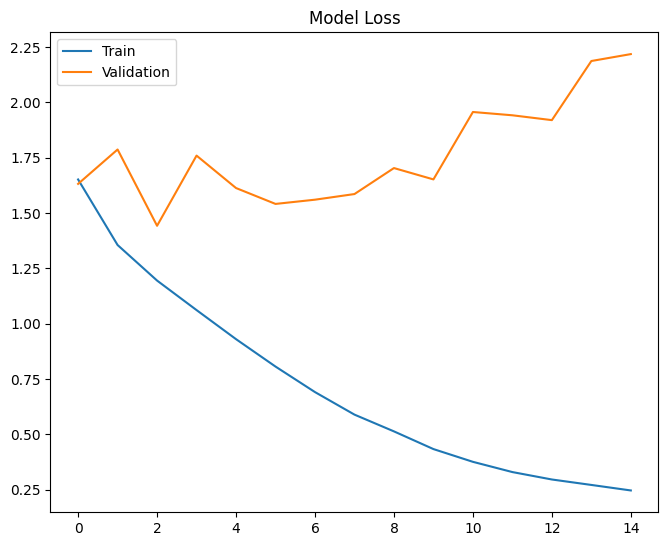

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train','Validation'],loc='upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0.0,hspace=0.25,wspace=0.35)

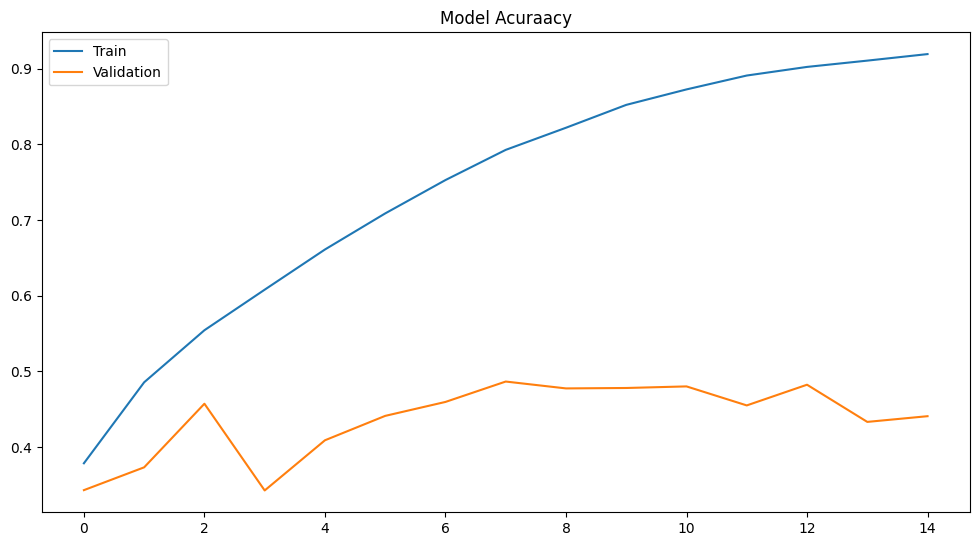

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Acuraacy')
plt.legend(['Train','Validation'],loc='upper left')
plt.subplots_adjust(top=1.5,bottom=0.5,right=1.95,left=0.5,hspace=0.75,wspace=0.65)

**Saving Model**

In [23]:
model_json=model.to_json()
with open ("model_a.json","w") as json_file:
    json_file.write(model_json)